<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/agni/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Example



## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wfdb
!pip install scikit-learn
!pip install matplotlib
!pip install pyedflib

In [27]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, spectrogram, stft, find_peaks
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

In [4]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# train_dir = '/content/train/'
# os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


In [5]:
# Ορισμός της διαδρομής προς το EDF αρχείο
rec = 'r01'
file_path = f'/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Load QRS annotations
qrs_annotations = wfdb.rdann(f"/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf", "qrs")

# Extract QRS peak sample indices
qrs_peaks = qrs_annotations.sample

print("QRS Peak Sample Indices:", qrs_peaks[:10])

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
QRS Peak Sample Indices: [ 183  651 1118 1583 2049 2514 2982 3451 3920 4389]


In [6]:
rr_intervals = np.diff(qrs_peaks)
print("RR Intervals (samples):", rr_intervals[:10])

RR Intervals (samples): [468 467 465 466 465 468 469 469 469 468]


In [7]:
rr_intervals_sec = rr_intervals / fs
print("RR Intervals (seconds):", rr_intervals_sec[:10])
min_rr = np.min(rr_intervals_sec)
print("Minimum RR Interval (seconds):", min_rr)

RR Intervals (seconds): [0.468 0.467 0.465 0.466 0.465 0.468 0.469 0.469 0.469 0.468]
Minimum RR Interval (seconds): 0.4


In [8]:
instantaneous_hr_hz = 1 / rr_intervals_sec
instantaneous_hr_bpm = instantaneous_hr_hz * 60
print("Instantaneous Heart Rates (Hz):", instantaneous_hr_hz[:10])
print("Instantaneous Heart Rates (bpm):", instantaneous_hr_bpm[:10])
print(np.max(instantaneous_hr_hz))

Instantaneous Heart Rates (Hz): [2.13675214 2.14132762 2.15053763 2.14592275 2.15053763 2.13675214
 2.13219616 2.13219616 2.13219616 2.13675214]
Instantaneous Heart Rates (bpm): [128.20512821 128.47965739 129.03225806 128.75536481 129.03225806
 128.20512821 127.93176972 127.93176972 127.93176972 128.20512821]
2.5


## Testing

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Σχήμα signals: (300000, 5)


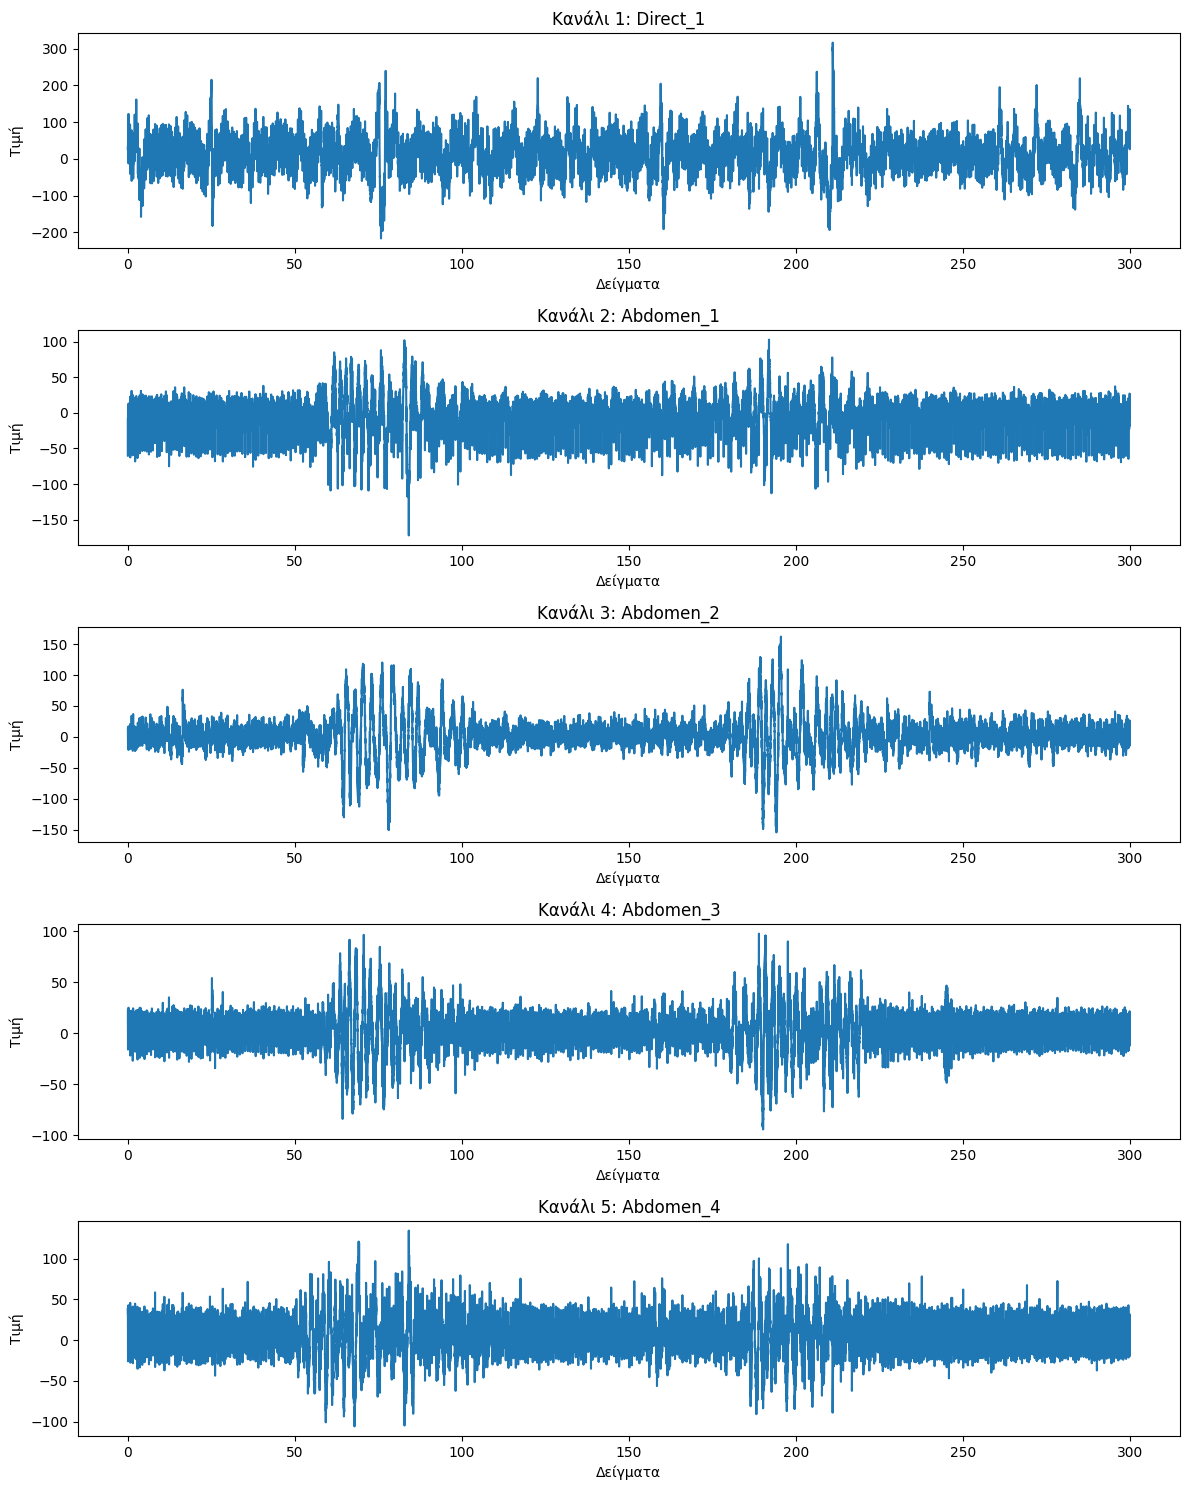

In [17]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = f'/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
signals = np.array(signals_list).T
print("Σχήμα signals:", signals.shape)

n_samples = signals.shape[0]
time = np.arange(n_samples) / fs
n_channels = signals.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(time, signals[:, i])
    plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')

plt.tight_layout()
plt.show()


Demixing Matrix W:
 [[-0.0357097  -0.00134496  0.0082699   0.02734944]
 [-0.02307655  0.02854131 -0.00722432 -0.03079716]
 [-0.02256592 -0.02154097 -0.01342223 -0.02386771]]
Demixing Matrix W shape:
 (3, 4)


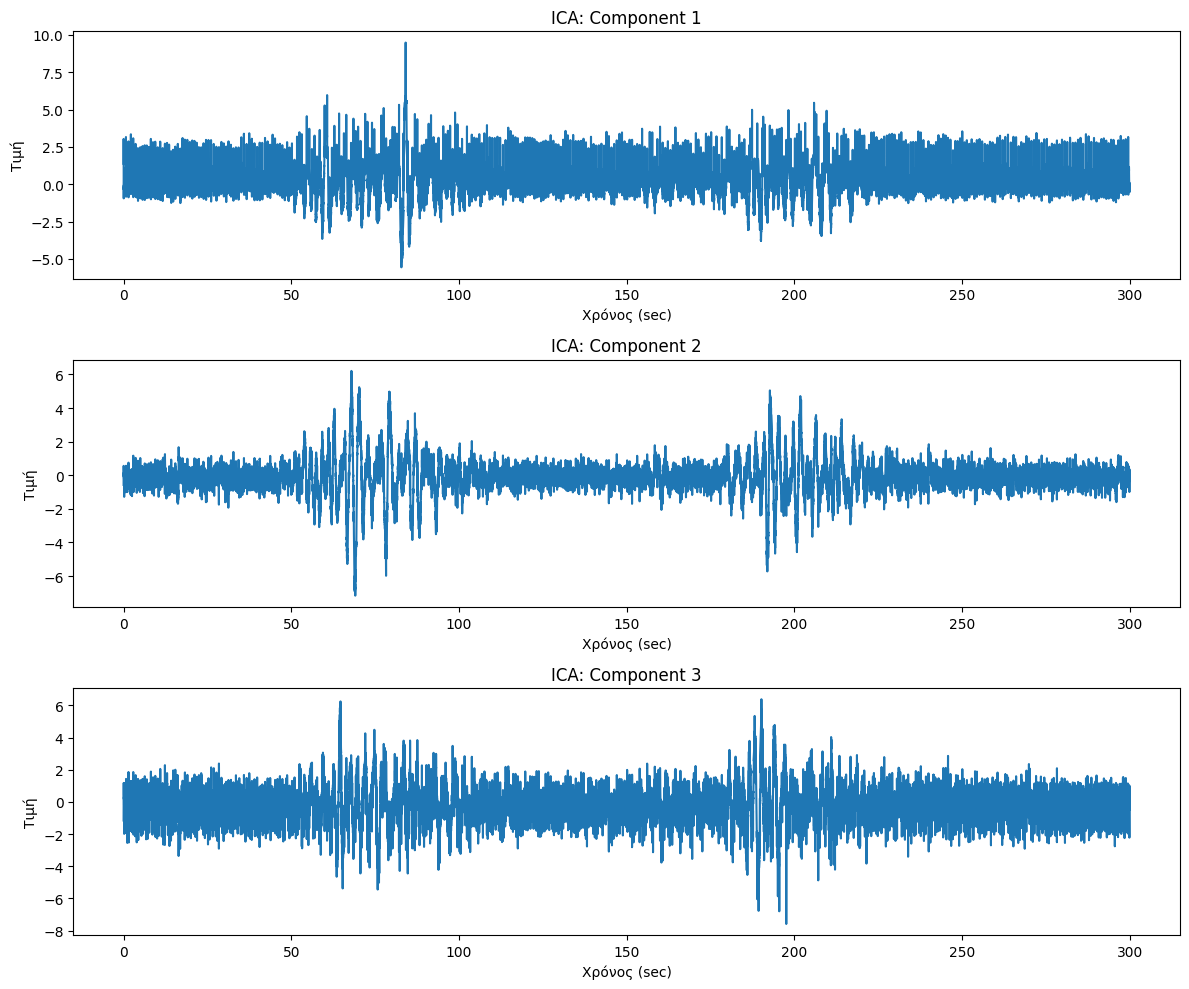

(300000, 5)
ica_components.shape: (300000, 3)


In [18]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
n_components = 3

ica = FastICA(n_components, whiten="unit-variance")
# ica_components = ica.fit_transform(signals)  # ΟΧΙ filtered_signals !!!!!!!
S_ = ica.fit_transform(signals[:,1:])
W = ica.components_

ica_components = S_

print("Demixing Matrix W:\n", W)
print("Demixing Matrix W shape:\n", W.shape)

time = np.arange(ica_components.shape[0]) / fs

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(ica_components.shape[1], 1, i + 1)
    plt.plot(time, ica_components[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

print(signals.shape)
print("ica_components.shape:", ica_components.shape)

# FFT ✨

In [34]:
fs = int(fs)

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    signal_i = ica_components[:, i]
    f, Pxx = signal.welch(signal_i, fs, nperseg=1024)
    plt.figure(figsize=(8, 4))
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    signal_i = ica_components[:, i]
    f, Pxx = signal.welch(signal_i, fs, nperseg=1024)
    plt.figure(figsize=(8, 4))
    plt.semilogy(f, Pxx)
    plt.xlim(0, 30)
    plt.title(f'Power Spectral Density {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'welch'

<Figure size 1200x1000 with 0 Axes>

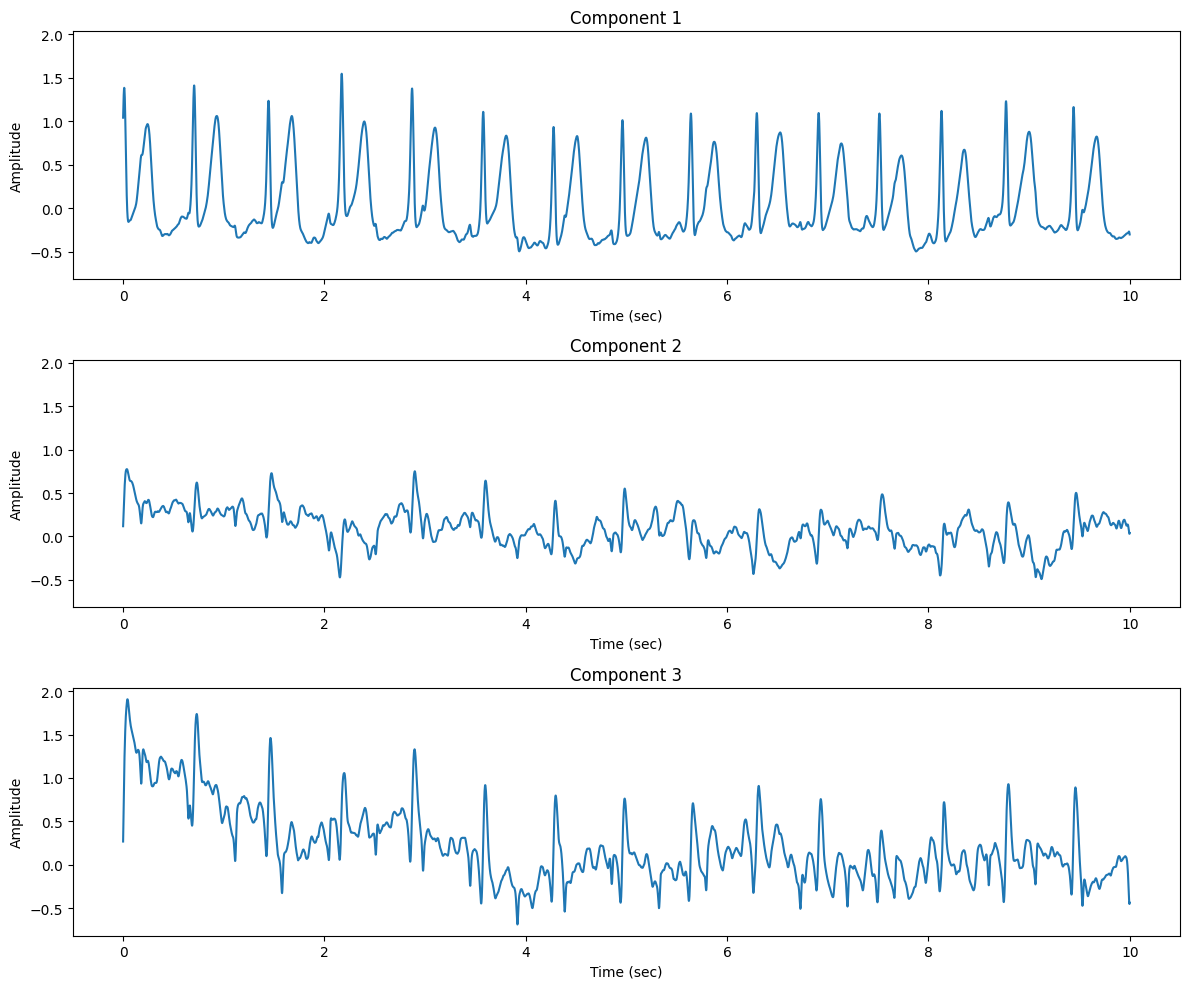

In [29]:
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[1]):
    filtered_signals[:, i] = bandpass_filter(
        data=ica_components[:, i],
        lowcut= 0.1,
        highcut=10,
        fs=fs,
    )

fig, axes = plt.subplots(filtered_signals.shape[1], 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[:10000], filtered_signals[:10000, i])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

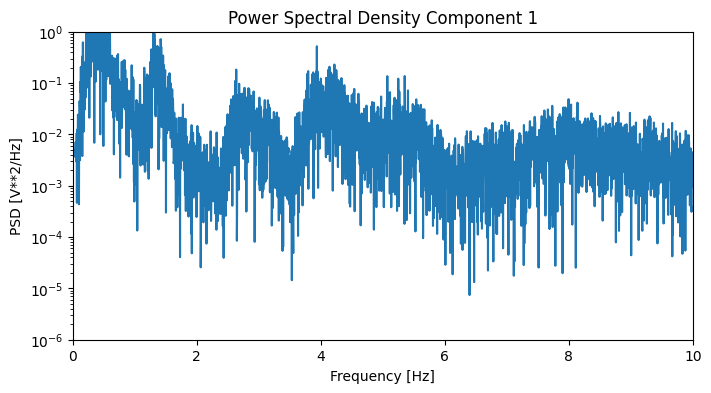

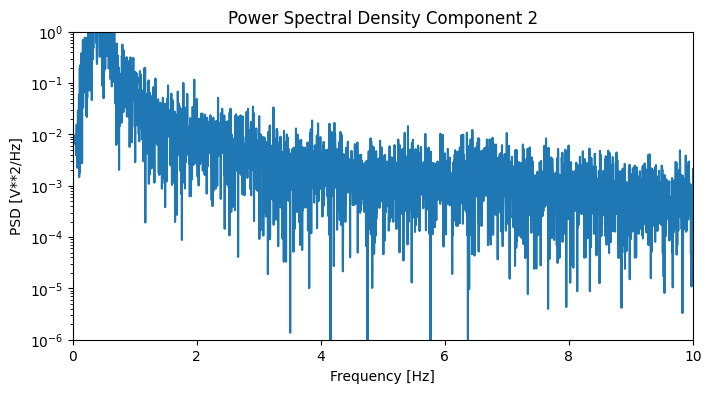

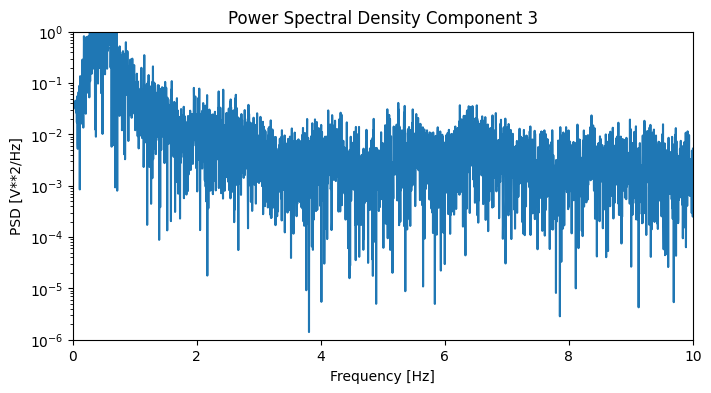

In [30]:
plt.figure(figsize=(12, 8))
for i in range(filtered_signals.shape[1]):
    signal_i = filtered_signals[:, i]

    X = np.fft.rfft(signal_i)
    freq = np.fft.rfftfreq(filtered_signals.shape[0], 1/fs)

    # Υπολογισμός του PSD με κατάλληλη κανονικοποίηση
    PSD = (1/(fs * filtered_signals.shape[0])) * np.abs(X)**2
    PSD[1:-1] = 2 * PSD[1:-1]

    # Εμφάνιση του PSD για το συγκεκριμένο component
    plt.figure(figsize=(8, 4))
    plt.semilogy(freq, PSD)
    plt.title(f'Power Spectral Density Component {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim(0, 10)  # Εστίαση στα Hz, περιοχή ενδιαφέροντος για ECG
    plt.ylim(1e-6, 1)
    plt.show()


Component 0: Fetal | HR: 88.07 bpm


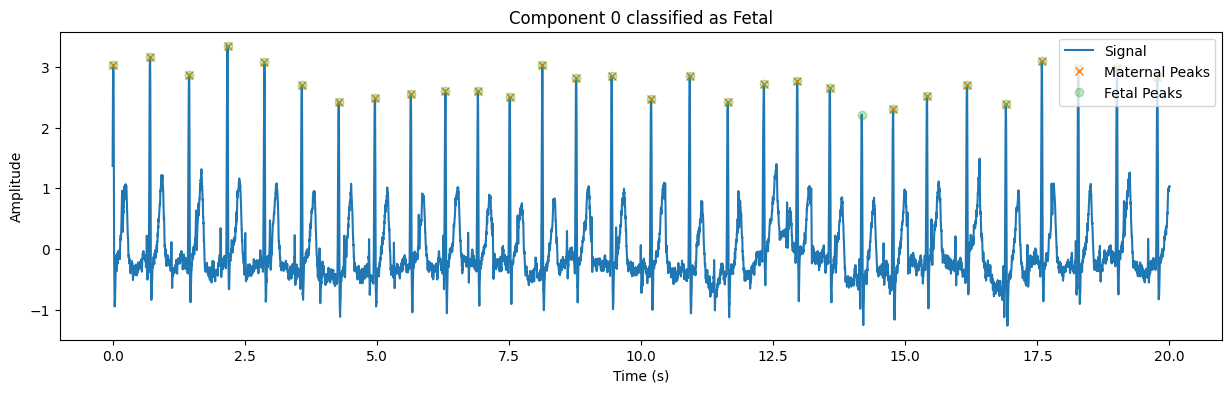

Component 1: Fetal | HR: 126.70 bpm


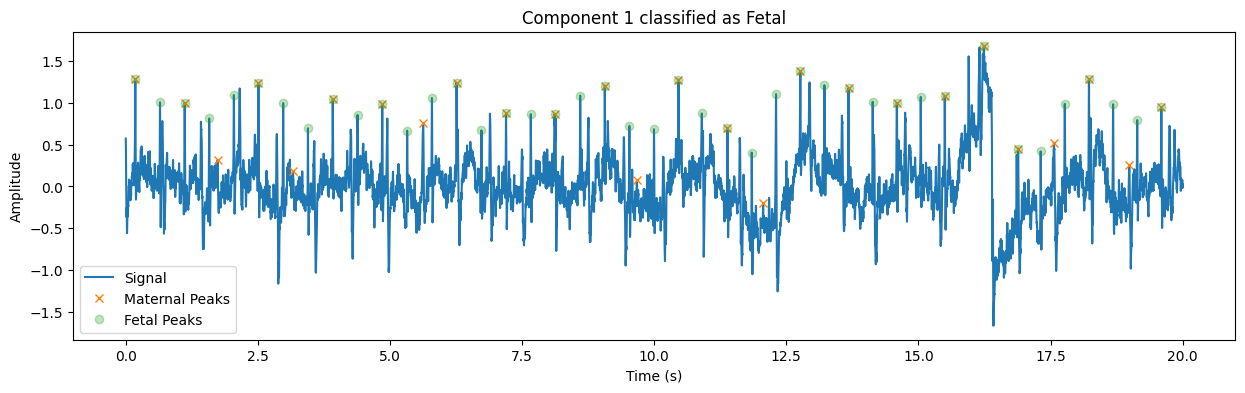

Component 2: Fetal | HR: 129.78 bpm


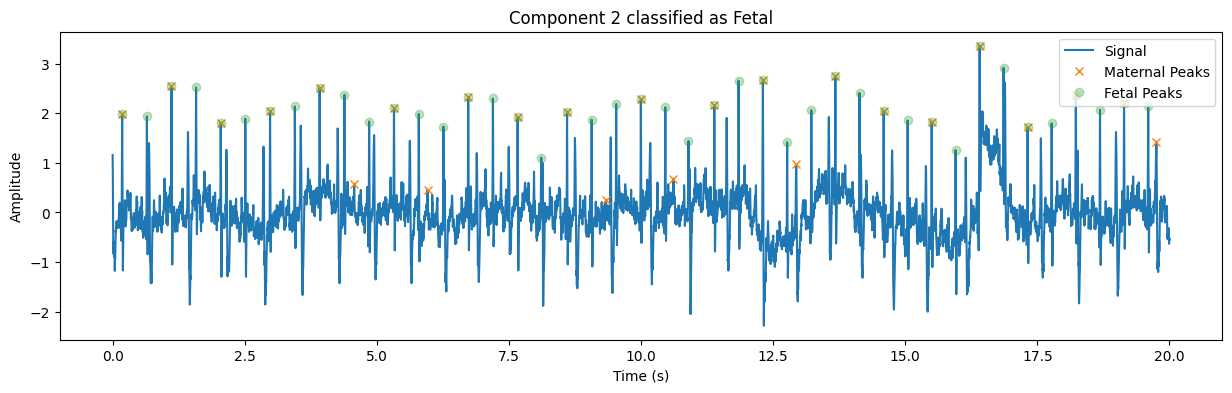

In [74]:
def classify_by_hr(hr_maternal, hr_fetal):
    if abs(hr_maternal - 80) < abs(hr_fetal - 120):
        return "Maternal", hr_maternal
    else:
        return "Fetal", hr_fetal

for i in range(ica_components.shape[1]):
    signal = ica_components[:20000, i]

    # Flip if average peak in -signal is stronger
    if np.max(-signal) > np.max(signal):
        signal = -signal


    # Maternal peaks
    maternal_peaks, _ = find_peaks(signal, distance=int(0.6*fs))

    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        hr_maternal = 60 / np.mean(maternal_rr)
    else:
        hr_maternal = np.nan

    # Fetal peaks
    fetal_peaks, _ = find_peaks(signal, distance=int(min_rr*fs))

    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs
        hr_fetal = 60 / np.mean(fetal_rr)
    else:
        hr_fetal = np.nan

    # Decide by heart rate closeness
    if not np.isnan(hr_maternal) and not np.isnan(hr_fetal):
        label, hr = classify_by_hr(hr_maternal, hr_fetal)
    if not np.isnan(hr_fetal):
        label, hr = "Fetal", hr_fetal
    elif not np.isnan(hr_maternal):
        label, hr = "Maternal", hr_maternal
    else:
        label, hr = "Noise", np.nan

    print(f"Component {i}: {label} | HR: {hr:.2f} bpm")

    # Optional plot:
    plt.figure(figsize=(15, 4))
    plt.plot(time[:20000], signal, label="Signal")
    plt.plot(time[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


fetal_rr: [0.696 0.742 0.725 0.697 0.709 0.697 0.687 0.678 0.655 0.613]
maternal_rr: [0.696 0.742 0.725 0.697 0.709 0.697 0.687 0.678 0.655 0.613]
Component 0: Maternal | HR: 81.93 bpm | Dom Freq: 0.5066666666666667 Hz


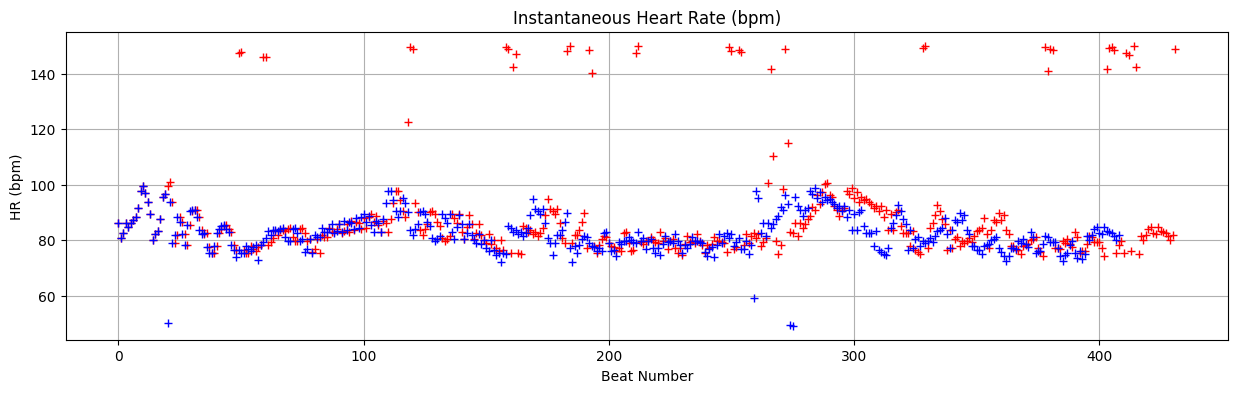

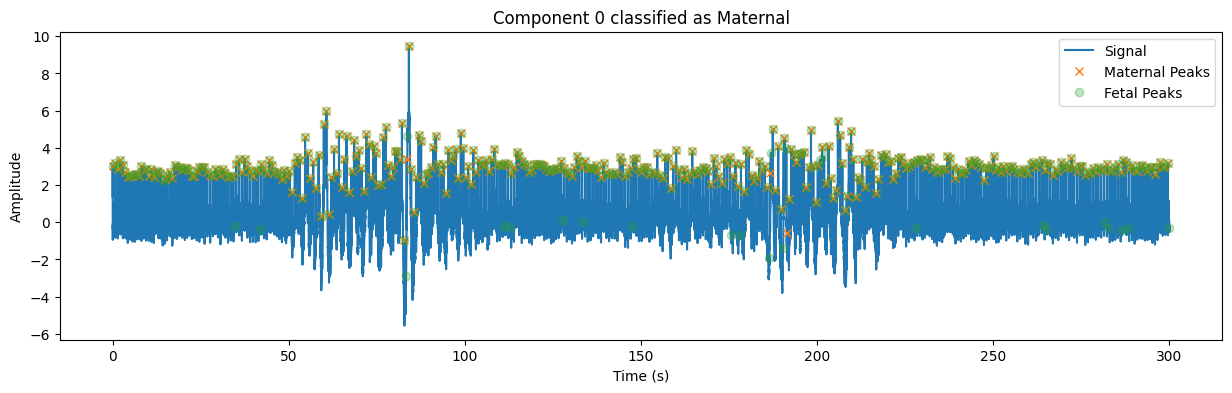

fetal_rr: [0.467 0.467 0.464 0.467 0.465 0.468 0.469 0.469 0.469 0.468]
maternal_rr: [0.934 0.623 0.773 0.654 0.752 0.937 0.774 0.632 0.936 0.918]
Component 1: Fetal or Noise | HR: 122.71 bpm | Dom Freq: 0.4166666666666667 Hz


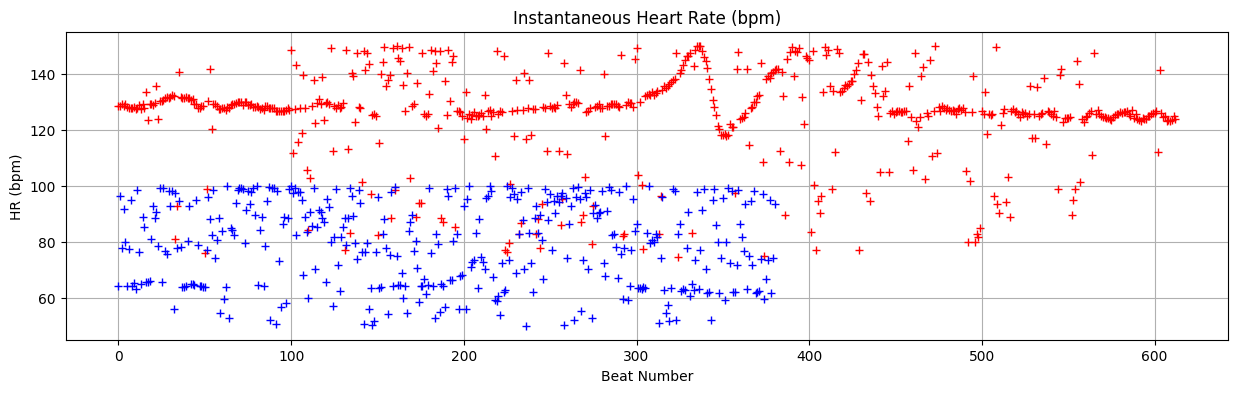

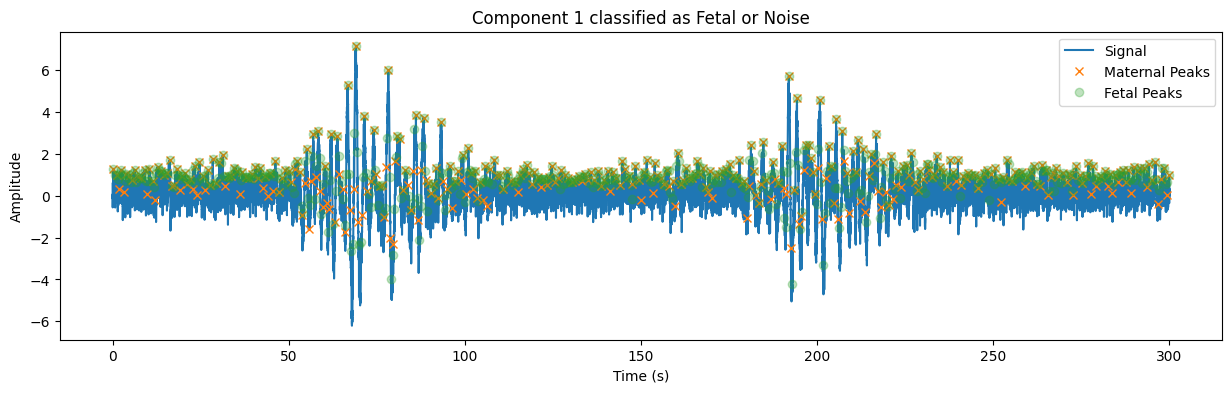

fetal_rr: [0.468 0.466 0.465 0.466 0.466 0.468 0.469 0.469 0.469 0.468]
maternal_rr: [0.934 0.931 0.934 0.938 0.654 0.753 0.635 0.77  0.935 0.935]
Component 2: Fetal or Noise | HR: 125.31 bpm | Dom Freq: 0.3466666666666667 Hz


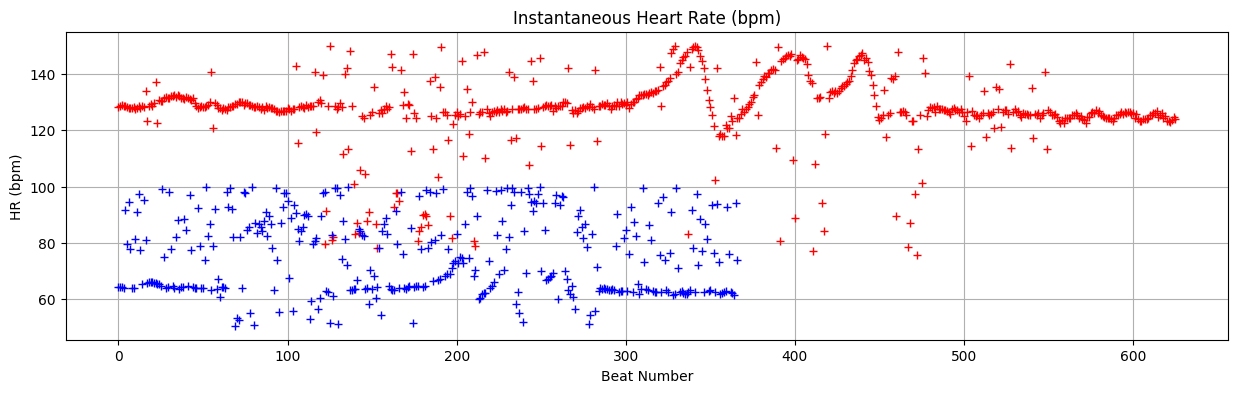

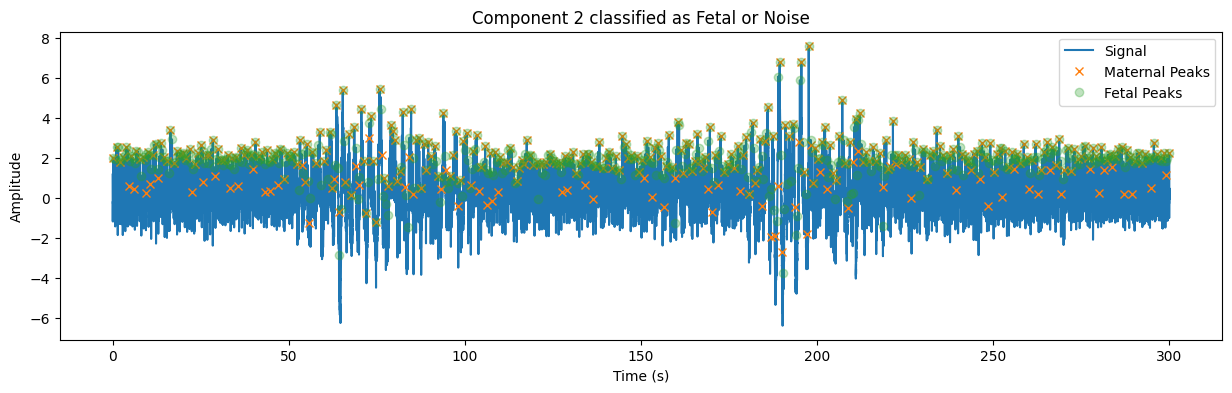

In [83]:
def classify_by_hr(hr_maternal, hr_fetal):
    if abs(hr_maternal - 80) < abs(hr_fetal - 120):
        return "Maternal", hr_maternal
    else:
        return "Fetal", hr_fetal

fetal_or_noise_signal = [ica_components.shape[0], 1]

for i in range(ica_components.shape[1]):
    duration_sec = 20 * fs
    signal = ica_components[:, i]

    # Flip if average peak in -signal is stronger
    if np.max(-signal) > np.max(signal):
        signal = -signal


    # Maternal peaks
    maternal_peaks, maternal_props = find_peaks(signal, distance=int(0.6*fs))

    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        hr_maternal = 60 / np.mean(maternal_rr)
    else:
        hr_maternal = np.nan

    # Fetal peaks
    fetal_peaks, fetal_props = find_peaks(signal, distance=int(min_rr*fs))

    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs # min_rr
        hr_fetal = 60 / np.mean(fetal_rr)
    else:
        hr_fetal = np.nan

    print(f"fetal_rr: {fetal_rr[:10]}")
    print(f"maternal_rr: {maternal_rr[:10]}")

    density_fetal = len(fetal_peaks) / duration_sec
    density_maternal = len(maternal_peaks) / duration_sec

    consistency_fetal = np.std(fetal_rr)
    consistency_maternal = np.std(maternal_rr)

    # Frequency domain analysis
    yf = np.abs(np.fft.rfft(signal))
    xf = np.fft.rfftfreq(signal.shape[0], 1 / fs)

    # Limit to cardiac-relevant band (0.5–5 Hz)
    mask = (xf > 0.1) & (xf < 5)
    dominant_freq = xf[mask][np.argmax(yf[mask])]

    # if dominant_freq < 2.5:
    #     label, hr = "Fetal", hr_fetal
    # elif dominant_freq < 3.5:
    #     label, hr = "Maternal", hr_maternal
    # else:
    #     label, hr = "Noise", np.nan

    # print(f"Component {i}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq} Hz")

    fetal_ihr_hz = 1 / fetal_rr
    fetal_ihr_bpm = 60 / fetal_rr
    maternal_ihr_hz = 1 / maternal_rr
    maternal_ihr_bpm = 60 / maternal_rr

    if np.abs(np.mean(fetal_ihr_bpm) - np.mean(maternal_ihr_bpm)) > 10:
        label, hr = "Fetal or Noise", hr_fetal
        fetal_or_noise_signal.append(signal)
    else:
        label, hr = "Maternal", hr_maternal
    print(f"Component {i}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq} Hz")

    plt.figure(figsize=(15, 4))
    plt.plot(fetal_ihr_bpm, "r+", label="Fetal IHRs")
    plt.plot(maternal_ihr_bpm, "b+", label="Maternal IHRs")
    plt.title("Instantaneous Heart Rate (bpm)")
    plt.xlabel("Beat Number")
    plt.ylabel("HR (bpm)")
    plt.grid()
    plt.show()


    # Main plot:
    plt.figure(figsize=(15, 4))
    plt.plot(time[:], signal, label="Signal")
    plt.plot(time[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

ica_components.shape: (300000, 3)
ica_components[0].shape (first row): (3,)


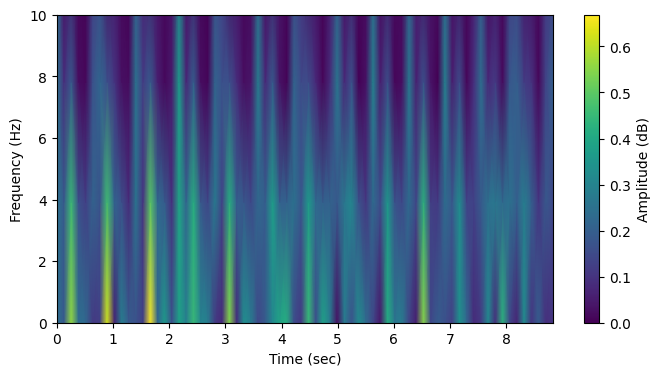

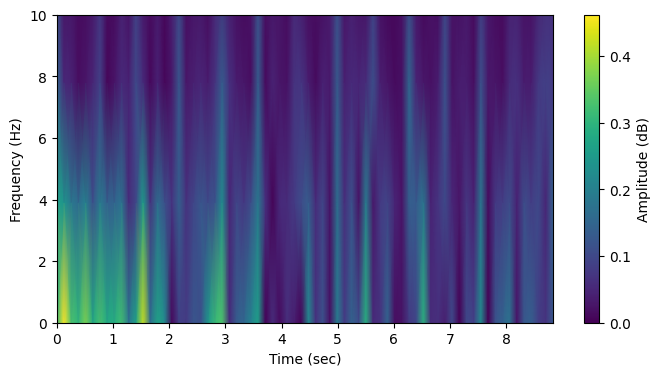

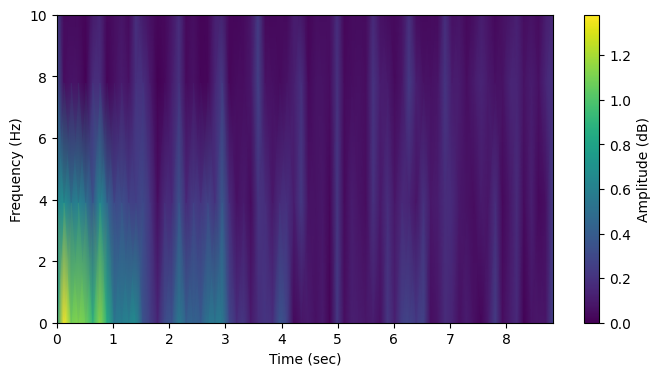

In [81]:
print("ica_components.shape:", ica_components.shape)
print("ica_components[0].shape (first row):", ica_components[0].shape)

time_limit = 70
for i in range(filtered_signals.shape[1]):
  # Compute the STFT on the selected component
  f, t, Zxx = stft(filtered_signals[:, i], fs=fs, nperseg=256)

  # print("Shape of f:", f.shape)
  # print("Shape of t:", t.shape)
  # print("Shape of Zxx:", Zxx.shape)

  # Plot the spectrogram
  plt.figure(figsize=(8, 4))
  plt.pcolormesh(t[:time_limit], f, np.abs(Zxx[:, :time_limit]), shading='gouraud')
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (sec)")
  plt.colorbar(label="Amplitude (dB)")
  plt.ylim([0, 10])
  plt.show()

[1.7934441  1.37086951 1.42319216] [157.67943228  67.08152055  54.85095027]


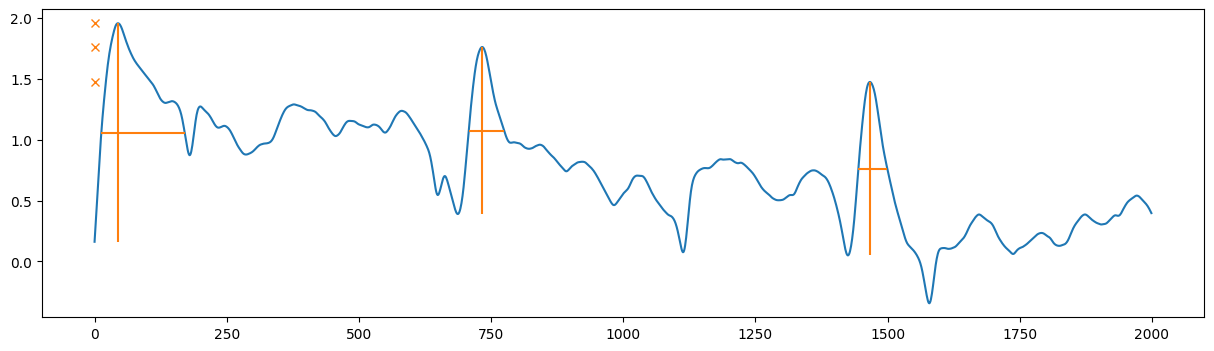

In [95]:
# Apply peak detection
expected_distance_samples = int(0.470 * fs)

x = filtered_signals[:2000, 0]
peaks, properties = find_peaks(x, distance=expected_distance_samples, prominence=1, width=20)
print(properties["prominences"], properties["widths"])

plt.figure(figsize=(15, 4))
plt.plot(x, label="ICA Component 2")
plt.plot(time[peaks], x[peaks], "x", label="Detected Peaks")
plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
           ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

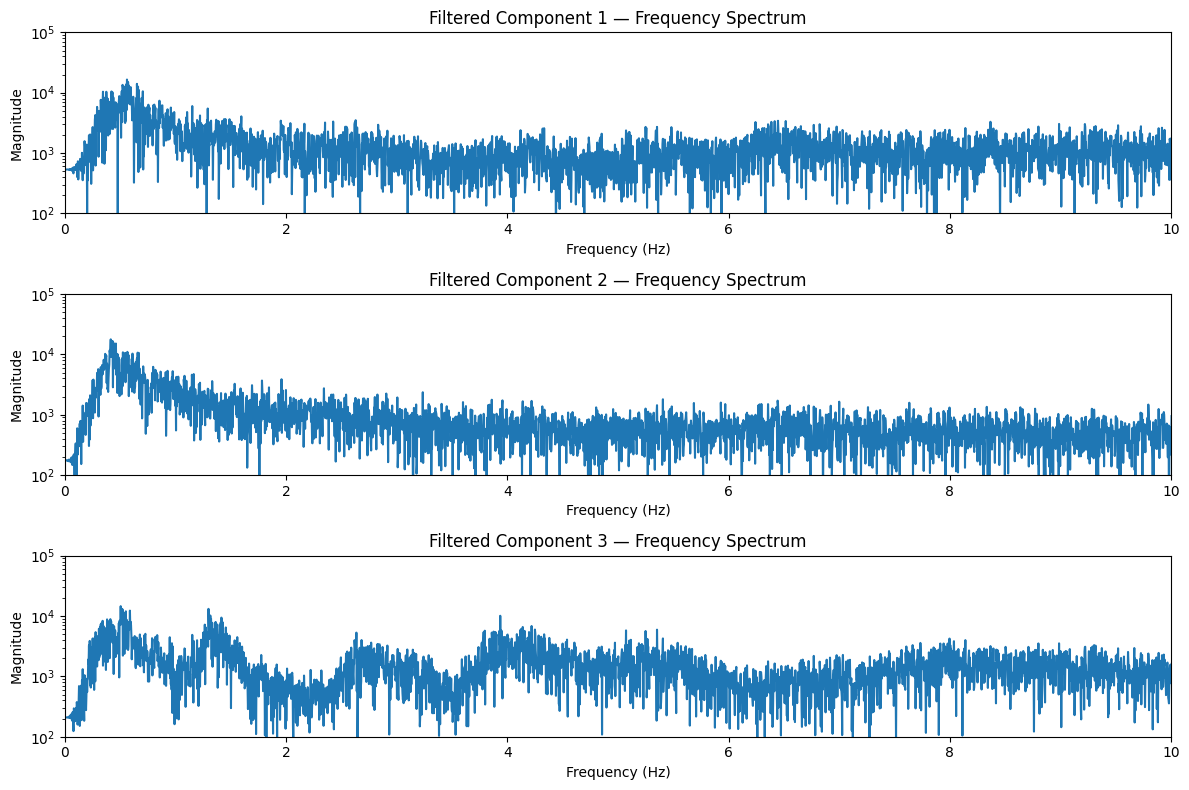

In [ ]:
# Number of samples
n = filtered_signals.shape[0]

# Frequency axis
freqs = np.fft.rfftfreq(n, d=1/fs)

# Compute spectra
fft_vals_list = [
    np.abs(np.fft.rfft(filtered_signals[:, i]))
    for i in range(filtered_signals.shape[1])
]

# Replace any NaN or Inf with zero
fft_vals_list = [np.nan_to_num(vals, nan=0.0, posinf=0.0, neginf=0.0)
                 for vals in fft_vals_list]

# Global y‑limit
ymax = max(vals.max() for vals in fft_vals_list)

# Plot
plt.figure(figsize=(12, 8))
for i, fft_vals in enumerate(fft_vals_list):
    plt.subplot(filtered_signals.shape[1], 1, i+1)
    plt.plot(freqs, fft_vals)
    plt.title(f'Filtered Component {i+1} — Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.yscale('log')
    plt.ylabel('Magnitude')
    plt.xlim(0, 10)  # Εστίαση στα Hz, περιοχή ενδιαφέροντος για ECG
    plt.ylim(1e2, 1e5)
plt.tight_layout()
plt.show()



In [ ]:
!pip install PyWavelets
import pywt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.6 MB/s eta 0:00:00


In [ ]:
# Parameters
time = np.arange(ica_components.shape[0]) / fs

# Choose wavelet + scales
wavelet = 'cmor1.5-1.0'        # complex Morlet
scales = np.arange(1, 128)    # adjust max scale for resolution

plt.figure(figsize=(12, 10))

for i in range(ica_components.shape[1]):
    signal = ica_components[:, i]

    # Compute CWT
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

    # Plot scalogram
    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)        # limit to fetal ECG band (~1–100 Hz)

plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.3 MB/s eta 0:00:00


KeyboardInterrupt: 

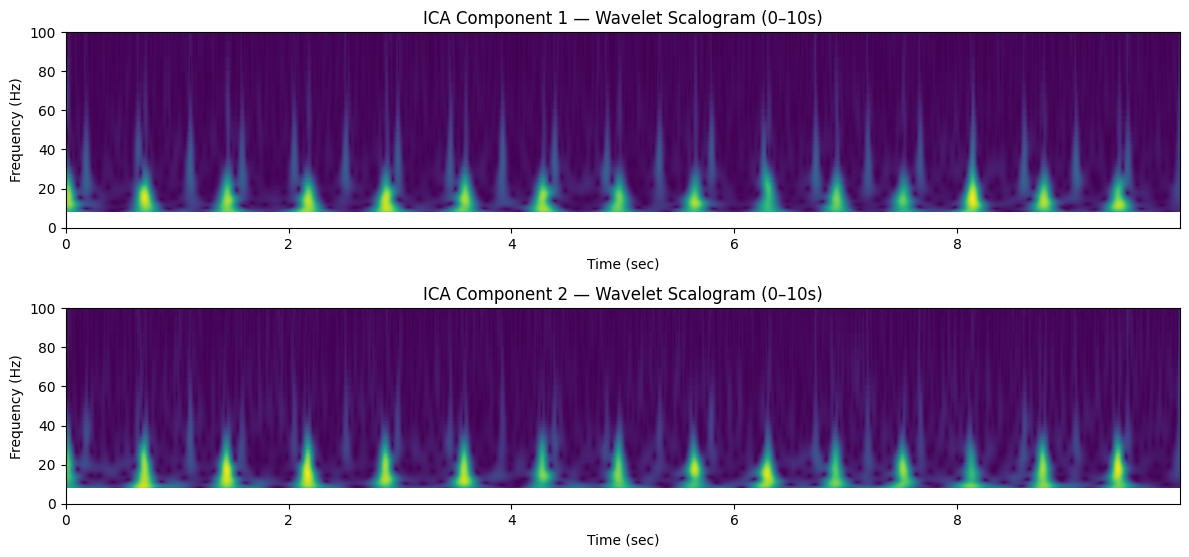

In [ ]:
end_idx = int(10 * fs)
time_limit = time[:end_idx]
time = np.arange(ica_components.shape[0]) / fs

wavelet = 'cmor1.5-1.0'         # complex Morlet
scales = np.arange(1, 128)      # max scale for resolution

plt.figure(figsize=(12, 8))
for i in range(ica_components.shape[1]):
    sig10 = ica_components[:end_idx, i]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()